Connect My drive

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-642343c8-b8f9-27f8-42ab-7102680ec74a)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install wandb
!pip install keras-tuner
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.9 MB/s eta 0:00:00


In [1]:
import os
import random
import shutil
import tensorflow as tf
# import optuna
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from wandb.keras import WandbCallback
import matplotlib.cm as cmp
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import numpy as np  # Add this line to import NumPy
# import kerastuner as kt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Bidirectional, Dense, TimeDistributed

import wandb
from IPython.display import Image, display
import cv2



np.random.seed(1234)
tf.random.set_seed(5678)

print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

TensorFlow 2.10.1
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [5]:
!wandb login 3b6dca19e885b9cbf2e607df7c3594a13fa41ed4

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Separate data set

In [6]:
!unzip "/content/drive/MyDrive/Deep Learning/Dataset/Dataset.zip"
# !unzip "/content/drive/MyDrive/Nida/CI7310 Deep Learning/final_project/dataset/Dataset_no_horizontal.zip"
# !rm -rf Dataset/noads/.DS_Store Dataset/ads/.DS_Store


Archive:  /content/drive/MyDrive/Deep Learning/Dataset/Dataset.zip
 extracting: Dataset/ads/01.mp4      
 extracting: Dataset/ads/02.mp4      
 extracting: Dataset/ads/03.mp4      
 extracting: Dataset/ads/04.mp4      
 extracting: Dataset/ads/05.mp4      
 extracting: Dataset/ads/06.mp4      
 extracting: Dataset/ads/07.mp4      
 extracting: Dataset/ads/08.mp4      
 extracting: Dataset/ads/09.mp4      
 extracting: Dataset/ads/1.mp4       
 extracting: Dataset/ads/10.mp4      
 extracting: Dataset/ads/11.mp4      
 extracting: Dataset/ads/12.mp4      
 extracting: Dataset/ads/13.mp4      
 extracting: Dataset/ads/14.mp4      
 extracting: Dataset/ads/15.mp4      
 extracting: Dataset/ads/16.mp4      
 extracting: Dataset/ads/17.mp4      
 extracting: Dataset/ads/18.mp4      
 extracting: Dataset/ads/19.mp4      
 extracting: Dataset/ads/2.mp4       
 extracting: Dataset/ads/20.mp4      
 extracting: Dataset/ads/21.mp4      
 extracting: Dataset/ads/22.mp4      
 extracting: Dataset/

In [ ]:
!rm -rf Dataset augment_data

In [ ]:
import cv2
import os

def resize_and_reduce_framerate(input_path, output_path, width, height, target_framerate):
    # Open the video file
    video_capture = cv2.VideoCapture(input_path)

    # Get the frames per second (fps) and video size
    original_framerate = video_capture.get(cv2.CAP_PROP_FPS)
    size = (int(width), int(height))

    # Calculate the number of frames to skip to achieve the target frame rate
    frame_skip = int(original_framerate / target_framerate)

    # Create VideoWriter object to save the output video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can change the codec as needed
    video_writer = cv2.VideoWriter(output_path, fourcc, target_framerate, size)

    # Read, resize, and skip frames to achieve the target frame rate
    frame_count = 0
    while True:
        ret, frame = video_capture.read()
        if not ret:
            break

        # Increment frame count
        frame_count += 1

        # Skip frames to achieve the target frame rate
        if frame_count % frame_skip != 0:
            continue

        # Resize the frame
        resized_frame = cv2.resize(frame, size)

        # Write the resized frame to the output video
        video_writer.write(resized_frame)

    # Release the video capture and writer objects
    video_capture.release()
    video_writer.release()

if __name__ == "__main__":
    dataset_folder = "Dataset"
    output_folder = "augment_data"
    width = 240
    height = 426
    target_framerate = 1

    # Process 'noads' videos
    noads_folder = os.path.join(dataset_folder, "noads")
    output_noads_folder = os.path.join(output_folder, "noads")
    os.makedirs(output_noads_folder, exist_ok=True)

    for filename in os.listdir(noads_folder):
        if filename.endswith(".mp4"):
            input_path = os.path.join(noads_folder, filename)
            output_path = os.path.join(output_noads_folder, filename)
            resize_and_reduce_framerate(input_path, output_path, width, height, target_framerate)

    # Process 'ads' videos
    ads_folder = os.path.join(dataset_folder, "ads")
    output_ads_folder = os.path.join(output_folder, "ads")
    os.makedirs(output_ads_folder, exist_ok=True)

    for filename in os.listdir(ads_folder):
        if filename.endswith(".mp4"):
            input_path = os.path.join(ads_folder, filename)
            output_path = os.path.join(output_ads_folder, filename)
            resize_and_reduce_framerate(input_path, output_path, width, height, target_framerate)


# Preprocessing data

In [7]:
import cv2
import os

def get_min_frame_count(folder_path):
    min_frame_count = float('inf')  # initialize with positive infinity

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".mp4"):
                video_path = os.path.join(root, file)
                cap = cv2.VideoCapture(video_path)

                # Check if the video file is opened successfully
                if not cap.isOpened():
                    print(f"Error opening video file: {video_path}")
                    continue

                frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                min_frame_count = min(min_frame_count, frame_count)

                # Release the video capture object
                cap.release()

    return min_frame_count

# Specify your dataset folder path
dataset_folder = "Dataset"

# Get the minimal frame count
min_frame_count = get_min_frame_count(dataset_folder)

# Print the result
print(f"The minimal frame count of all MP4 files is: {min_frame_count}")

The minimal frame count of all MP4 files is: 95


In [8]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import math

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
dataset_path = 'Dataset'
img_height = 224
img_width = 224
num_channels = 3  # RGB images
seq_length = 10  # Number of frames per video

def read_video(file_path,seq):
    cap = cv2.VideoCapture(file_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (img_width, img_height))
        frames.append(frame)
    cap.release()

    # for input frame of total
    sequence= []
    new_seq = math.floor(len(frames) / seq_length)

    for x in range(seq_length):
      if(x==0):
        sequence.append(frames[new_seq*x])
      else:
        sequence.append(frames[(new_seq*x)-3])


    # if len(frames) >= seq:
    #     # Randomly select a sequence of frames
    #     start_idx = np.random.randint(0, len(frames) - seq + 1)
    #     sequence = frames[start_idx:start_idx + seq]
    return np.array(sequence)

def preprocess_data(dataset_path):
    X = []
    y = []

    for label, folder in enumerate(['noads', 'ads']):
        folder_path = os.path.join(dataset_path, folder)
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            frames = read_video(file_path,seq_length)

            # if len(frames) >= seq_length:
            #     # Randomly select a sequence of frames
            #     start_idx = np.random.randint(0, len(frames) - seq_length + 1)
            #     sequence = frames[start_idx:start_idx + seq_length]

            #     X.append(sequence)
            #     y.append(label)

            # Ensure the video has enough frames
            # if len(frames) >= seq_length:
            #     # Randomly select a sequence of frames

            #     sequence = frames[0:seq_length]

            X.append(frames)
            y.append(label)

    return np.array(X), np.array(y)

# min_frame_count = findMinFrame_data(dataset_path)
# print(f"The minimal frame count of all MP4 files is: {min_frame_count}")
# Preprocess the data
X, y = preprocess_data(dataset_path)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (163, 10, 224, 224, 3)
y_train shape: (163,)
X_test shape: (41, 10, 224, 224, 3)
y_test shape: (41,)


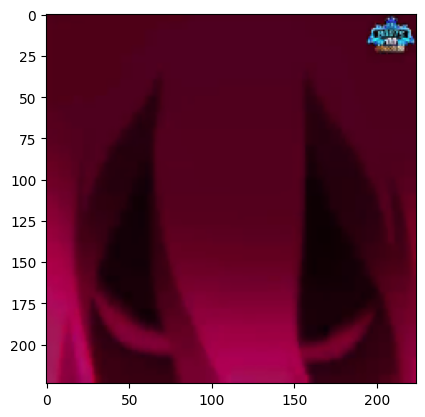

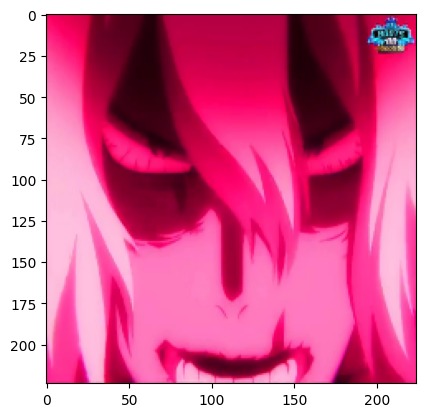

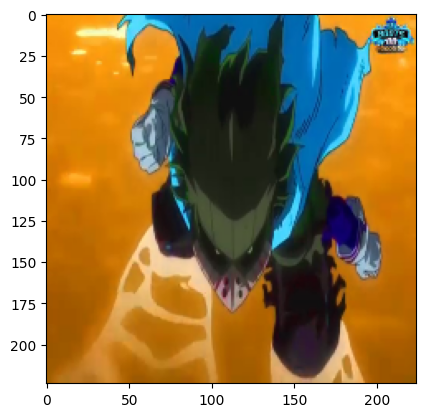

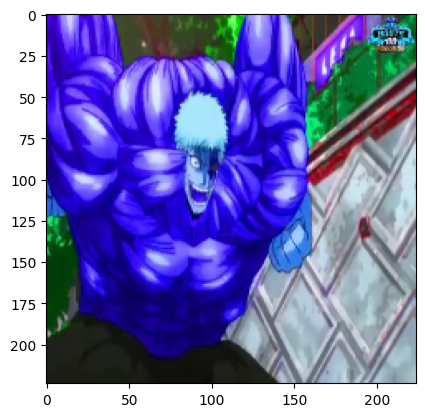

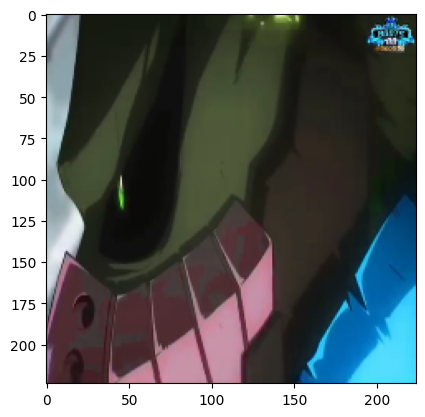

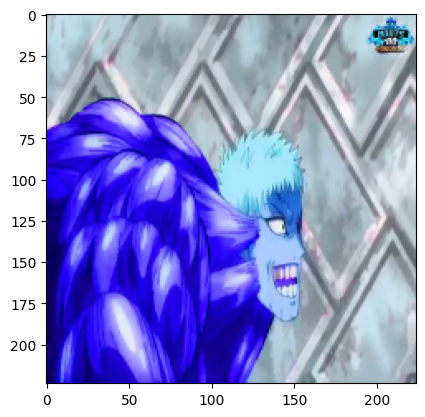

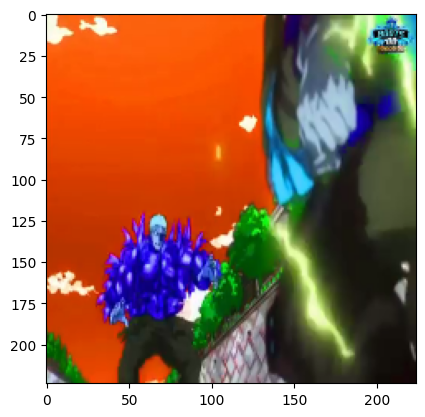

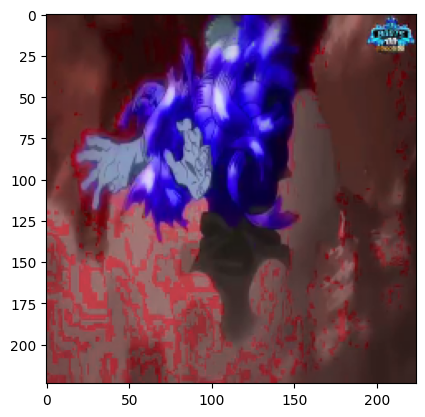

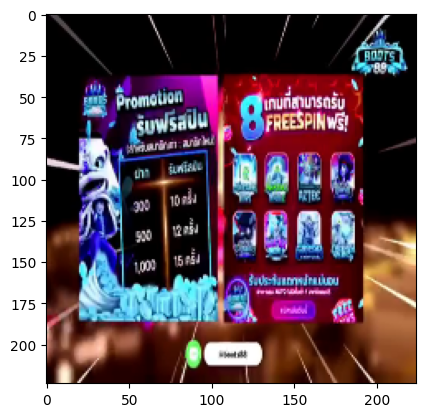

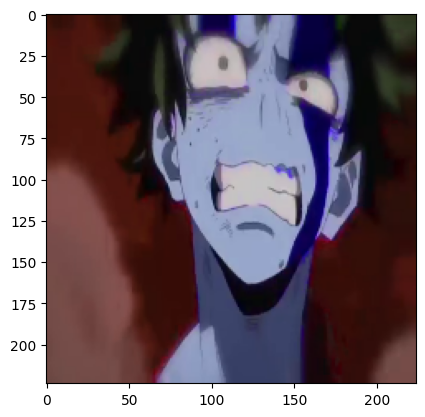

In [9]:
def visualize_video(video_frames):
    # Display each frame in the video
    for frame in video_frames:
        plt.imshow(frame)
        plt.show()

# Choose a random video from the training set to visualize
random_index = np.random.randint(0, len(X_train))
random_video = X_train[random_index]

# Visualize the chosen video
visualize_video(random_video)

In [10]:

def visualize_and_save_video(video_frames, output_path='output_video.mp4'):
    # Get the height and width of the frames
    height, width, _ = video_frames[0].shape

    # Create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can also use 'XVID' or other codecs
    out = cv2.VideoWriter(output_path, fourcc, 5.0, (width, height))

    # Write each frame to the video file
    for frame in video_frames:
        out.write(frame)

    # Release the VideoWriter
    out.release()

# Choose a random video from the training set to visualize
random_index = np.random.randint(0, len(X_train))
random_video = X_train[random_index]

# Visualize and save the chosen video
output_path = 'output_video.mp4'
visualize_and_save_video(random_video, output_path)

print(f"Video saved to {output_path}")

Video saved to output_video.mp4


# CNN-BiLSTM Model

In [11]:
import wandb
for label, batchSize in enumerate([32]):

    project = "jirawat_CNN-BiLSTM" #@param {type:"string"}
    epochs = 20 #@param {type:"number"}
    learning_rate = 0.0001 #@param {type:"number"}

    config={
        "learning_rate": learning_rate,
        "architecture": "CNN-BiLSTM",
        "dataset": "grambling",
        "epochs": epochs,
        }
    # Initialize wandb with your project name and any other configuration you need
    wandb.init(project=project,entity="deep-a",name=f'CNN-BiLSTM-skip-frame-{batchSize}', config=config)

    # # Build the CNN-LSTM model
    model = tf.keras.Sequential([
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'), input_shape=(seq_length, img_height, img_width, num_channels)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2))),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=batchSize, validation_split=0.2,callbacks=[WandbCallback()])

    # Evaluate the model on the test set
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')
    accuracy_values = history.history['accuracy']
    mean_accuracy = np.mean(accuracy_values)
    std_accuracy = np.std(accuracy_values)
    loss_values = history.history['loss']
    mean_loss = np.mean(loss_values)
    std_loss = np.std(loss_values)

    # Log mean and standard deviation on WandB
    wandb.log({"Mean Accuracy": mean_accuracy, "SD Accuracy": std_accuracy})
    wandb.log({"Mean Loss": mean_loss, "SD Loss": std_loss})
    avg_epoch_time = np.mean(np.diff(history.epoch))  # Assuming 'history.epoch' contains epoch end times

    # Log average epoch time on WandB
    wandb.log({"Average Epoch Time": avg_epoch_time})

    model.save(f'CNN-BiLSTM_model-{batchSize}.h5')
    wandb.finish()



wandb: Currently logged in as: tar-relate (deep-a). Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/20
5/5 [==============================] - ETA: 0s - loss: 0.7119 - accuracy: 0.5000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231228_111610-5tli61y8/files/model-best)... Done. 44.5s


5/5 [==============================] - 125s 27s/step - loss: 0.7119 - accuracy: 0.5000 - val_loss: 0.6919 - val_accuracy: 0.5455
Epoch 2/20
5/5 [==============================] - ETA: 0s - loss: 0.7012 - accuracy: 0.4769

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231228_111610-5tli61y8/files/model-best)... Done. 36.0s


5/5 [==============================] - 105s 26s/step - loss: 0.7012 - accuracy: 0.4769 - val_loss: 0.6914 - val_accuracy: 0.5455
Epoch 3/20
5/5 [==============================] - ETA: 0s - loss: 0.7052 - accuracy: 0.4923

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231228_111610-5tli61y8/files/model-best)... Done. 40.2s


5/5 [==============================] - 104s 26s/step - loss: 0.7052 - accuracy: 0.4923 - val_loss: 0.6908 - val_accuracy: 0.5455
Epoch 4/20
5/5 [==============================] - ETA: 0s - loss: 0.7028 - accuracy: 0.4923

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231228_111610-5tli61y8/files/model-best)... Done. 67.1s


5/5 [==============================] - 123s 31s/step - loss: 0.7028 - accuracy: 0.4923 - val_loss: 0.6900 - val_accuracy: 0.5455
Epoch 5/20
5/5 [==============================] - 2s 456ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6903 - val_accuracy: 0.5455
Epoch 6/20
5/5 [==============================] - ETA: 0s - loss: 0.6828 - accuracy: 0.5769

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231228_111610-5tli61y8/files/model-best)... Done. 40.4s


5/5 [==============================] - 96s 24s/step - loss: 0.6828 - accuracy: 0.5769 - val_loss: 0.6884 - val_accuracy: 0.5455
Epoch 7/20
5/5 [==============================] - 3s 513ms/step - loss: 0.7245 - accuracy: 0.4846 - val_loss: 0.6888 - val_accuracy: 0.5455
Epoch 8/20
5/5 [==============================] - 2s 472ms/step - loss: 0.6924 - accuracy: 0.5846 - val_loss: 0.6891 - val_accuracy: 0.5455
Epoch 9/20
5/5 [==============================] - 2s 445ms/step - loss: 0.6970 - accuracy: 0.5462 - val_loss: 0.6890 - val_accuracy: 0.5455
Epoch 10/20
5/5 [==============================] - 2s 472ms/step - loss: 0.6960 - accuracy: 0.5000 - val_loss: 0.6893 - val_accuracy: 0.5455
Epoch 11/20
5/5 [==============================] - 2s 479ms/step - loss: 0.6920 - accuracy: 0.5231 - val_loss: 0.6897 - val_accuracy: 0.5455
Epoch 12/20
5/5 [==============================] - 2s 447ms/step - loss: 0.7078 - accuracy: 0.4769 - val_loss: 0.6889 - val_accuracy: 0.5455
Epoch 13/20
5/5 [============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231228_111610-5tli61y8/files/model-best)... Done. 15.9s


5/5 [==============================] - 95s 24s/step - loss: 0.6824 - accuracy: 0.5000 - val_loss: 0.6882 - val_accuracy: 0.5455
Epoch 15/20
5/5 [==============================] - 2s 439ms/step - loss: 0.6962 - accuracy: 0.5462 - val_loss: 0.6887 - val_accuracy: 0.5455
Epoch 16/20
5/5 [==============================] - 2s 437ms/step - loss: 0.7089 - accuracy: 0.4846 - val_loss: 0.6893 - val_accuracy: 0.5455
Epoch 17/20
5/5 [==============================] - 2s 462ms/step - loss: 0.6927 - accuracy: 0.5154 - val_loss: 0.6896 - val_accuracy: 0.5455
Epoch 18/20
5/5 [==============================] - 2s 462ms/step - loss: 0.6819 - accuracy: 0.5308 - val_loss: 0.6899 - val_accuracy: 0.5455
Epoch 19/20
5/5 [==============================] - 2s 475ms/step - loss: 0.6902 - accuracy: 0.5385 - val_loss: 0.6908 - val_accuracy: 0.5455
Epoch 20/20
2/2 [==============================] - 1s 864ms/step - loss: 0.6939 - accuracy: 0.4878
Test Loss: 0.6939, Test Accuracy: 0.4878


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Average Epoch Time,▁
Mean Accuracy,▁
Mean Loss,▁
SD Accuracy,▁
SD Loss,▁
accuracy,▂▁▂▂▂▇▁█▅▂▄▁▂▂▅▁▃▄▅▃
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,▆▄▅▄▃▁█▃▃▃▃▅▇▁▃▅▃▁▂▄
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▄▅▁▂▃▂▃▄▂▁▁▂▃▄▄▆▂
Average Epoch Time,1.0


2/2 [==============================] - 2s 14ms/step


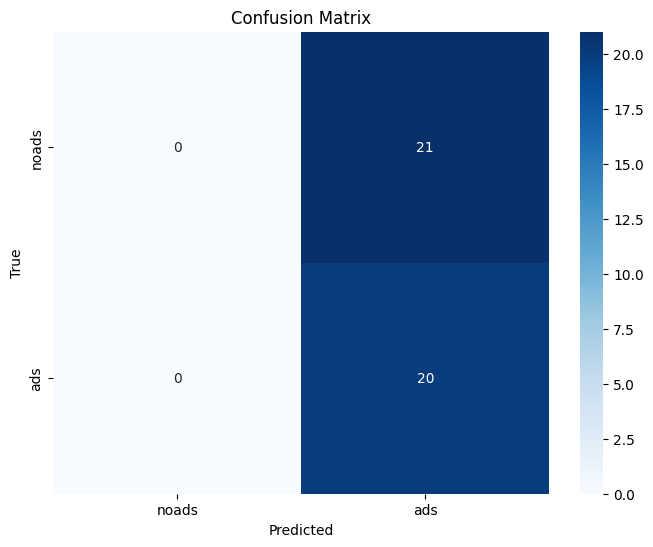

In [12]:
y_pred = model.predict(X_test)
y_pred_binary = np.round(y_pred)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['noads', 'ads'], yticklabels=['noads', 'ads'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# VGG-BiLSTM Model

In [ ]:
import wandb
for label, batchSize in enumerate([16, 32]):

    project = "jirawat_VGG-BiLSTM" #@param {type:"string"}
    epochs = 20 #@param {type:"number"}
    learning_rate = 0.0001 #@param {type:"number"}

    config={
        "learning_rate": learning_rate,
        "architecture": "VGG-BiLSTM",
        "dataset": "grambling",
        "epochs": epochs,
        }
    # Initialize wandb with your project name and any other configuration you need
    wandb.init(project=project,entity="deep-a",name=f'VGG-BiLSTM-skip-frame-{batchSize}', config=config)

    # # Load pre-trained VGG16 model
    vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, num_channels))
    # Freeze convolutional layers
    for layer in vgg_model.layers:
        layer.trainable = False
    # # Build the VGG-LSTM model with pre-trained VGG16
    model = Sequential([
        TimeDistributed(vgg_model, input_shape=(seq_length, img_height, img_width, num_channels)),
        TimeDistributed(Flatten()),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])


    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=batchSize, validation_split=0.2,callbacks=[WandbCallback()])

    # Evaluate the model on the test set
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')
    accuracy_values = history.history['accuracy']
    mean_accuracy = np.mean(accuracy_values)
    std_accuracy = np.std(accuracy_values)
    loss_values = history.history['loss']
    mean_loss = np.mean(loss_values)
    std_loss = np.std(loss_values)

    # Log mean and standard deviation on WandB
    wandb.log({"Mean Accuracy": mean_accuracy, "SD Accuracy": std_accuracy})
    wandb.log({"Mean Loss": mean_loss, "SD Loss": std_loss})
    avg_epoch_time = np.mean(np.diff(history.epoch))  # Assuming 'history.epoch' contains epoch end times

    # Log average epoch time on WandB
    wandb.log({"Average Epoch Time": avg_epoch_time})

    model.save(f'VGG-BiLSTM_model-{batchSize}.h5')
    wandb.finish()



In [ ]:
y_pred = model.predict(X_test)
y_pred_binary = np.round(y_pred)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['noads', 'ads'], yticklabels=['noads', 'ads'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')


In [ ]:
#Summarize history of accuracy
plt.figure(figsize = (15,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.grid()
plt.show()

In [ ]:
#Summarize history for loss
plt.figure(figsize = (15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper right')
plt.grid()
plt.show()

In [ ]:
model.summary()
